# Converting our signals from Volts to Protons / other units 

In [1]:
import glob
import math
#import time
#import string
import pandas as pd
import numpy as np
import scipy
import scipy.interpolate as interp
import scipy.integrate as integrate
#import random
#import paho.mqtt.client as mqtt
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec

from scipy.constants import c, m_p, e

In [2]:
# From Group 1A: Data Filter Class
import data_filter as df

In [3]:
def synchrotron_momentum(max_E, time):
    mpeV = m_p * c**2 / e           # Proton mass in eV
    R0 = 26                         # Mean machine radius
    n_dip = 10                      # Number of dipoles
    dip_l = 4.4                     # Dipole length
    
    dip_angle = 2 * np.pi / n_dip   # Dipole bending angle
    rho = dip_l / dip_angle         # Dipole radius of curvature
    omega = 2 * np.pi * 50   
    
    Ek = np.array([70, max_E]) * 1e6 # Injection and extraction kinetic energies 
    E = Ek + mpeV                    # Injection and extraction kinetic energies
    p = np.sqrt(E**2 - mpeV**2)      # Injection and extraction momenta

    B = p / c / rho                  # Ideal magnetic field at injection and extraction energies
    
    Bdip = lambda t: (B[1] + B[0] - (B[1] - B[0]) * np.cos(omega * t)) / 2  # Idealised B-field variation with AC
    pdip = lambda t: Bdip(t) * rho * c                                      # Momentum from B-field in MeV
    
    return pdip(time*1E-3)

In [4]:
def synchrotron_kinetic_energy(max_E, time):
    mpeV = m_p * c**2 / e           # Proton mass in eV    
    # Relativistic Kinetic Energy = Relativistic Energy - mass
    return (np.sqrt(synchrotron_momentum(max_E, time)**2 + mpeV**2) - mpeV) # Return array in eV
    #return (np.sqrt(synchrotron_momentum(max_E, time)**2 + mpeV**2) - mpeV)/1E6 # Return array in MeV

In [5]:
# Function to fetch stored unfiltered dataframes

# fetch_stored_data(n, None, False) = R5IM loss data, n = glob file index not BLM index
# fetch_stored_data(n, None, True) = cycle data, n = glob file index not BLM index

def fetch_stored_data(index=0, folder=None, cycle=True):
    
    if folder is None:
        if cycle:
            folder = '../BLM_R5IM_Data/cycle/'
        else:
            folder = '../BLM_R5IM_Data/R5IM_loss/'
    
    if folder[-1] != '/': folder += '/'        
        
    input_data = pd.read_csv(glob.glob(folder + '*.csv')[index])
    return input_data.drop(columns = input_data.columns[0]).to_numpy()

In [6]:
labels = ["r0blm1", "r0blm3", "r0blm4", 
            "r1blm1", "r1blm2", "r1blm3", "r1blm4", 
            "r2blm1", "r2blm2", "r2blm3", "r2blm4", 
            "r3blm1", "r3blm2", "r3blm3", "r3blm4", 
            "r4blm1", "r4blm2", "r4blm3", "r4blm4", 
            "r5blm1", "r5blm2", "r5blm3", "r5blm4", 
            "r6blm1", "r6blm2", "r6blm3", "r6blm4", 
            "r7blm1", "r7blm2", "r7blm3", "r7blm4", 
            "r8blm1", "r8blm2", "r8blm3", "r8blm4", 
            "r9blm1", "r9blm2", "r9blm3", "r9blm4", "r5im"]

# Instantiate DataFilter Class

In [7]:
data_filter = df.DataFilter()

In [8]:
data_filter.set("invert", True, "r5im")

In [9]:
data_filter.set('auto_offset', 10)




## R5IM: Intensity Monitor 

In [10]:
R5IM_calibration_coefficient = 4E12

In [11]:
input_data = data_filter.apply(fetch_stored_data(0, None, False))
input_data_cycle = data_filter.apply(fetch_stored_data(0, None, True))

In [12]:
R5IM_data = input_data[39]
R5IM_data_cycle = input_data_cycle[39]

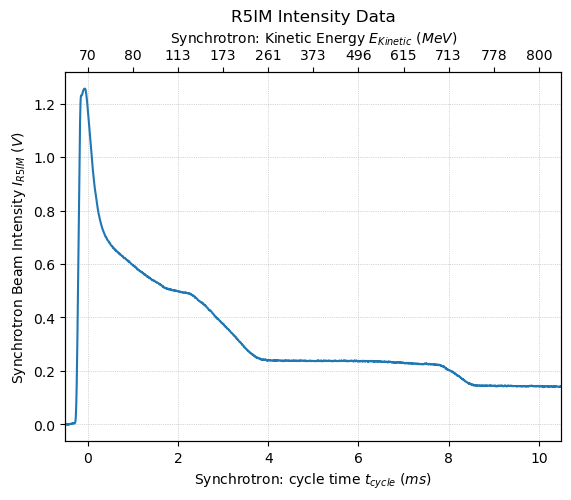

In [13]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
ax1.set_ylabel(r"Synchrotron Beam Intensity $I_{R5IM}$ $(V)$")

ax1.plot(np.linspace(-0.5, 10.5, 2200), R5IM_data)
ax1.set_xlim(-0.5, 10.5)
ax1.set_xlabel(r"Synchrotron: cycle time $t_{cycle}$ $(ms)$")
ax1.grid(which='both', ls=':', lw=0.5)

def tick_function(time):
    E = synchrotron_kinetic_energy(800., time)*1E-6
    return ["%.0f" % z for z in E]

ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(np.linspace(0., 10., 11))
ax2.set_xticklabels(tick_function(np.linspace(0., 10., 11)))
ax2.set_xlabel(r"Synchrotron: Kinetic Energy $E_{Kinetic}$ $(MeV)$");
plt.title('R5IM Intensity Data');

### Convert to Protons

In [14]:
R5IM_data_protons = R5IM_data * 4E12

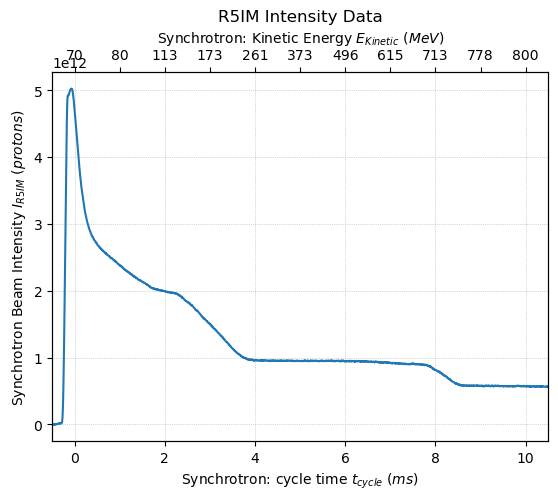

In [15]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
ax1.set_ylabel(r"Synchrotron Beam Intensity $I_{R5IM}$ $(protons)$")

ax1.plot(np.linspace(-0.5, 10.5, 2200), R5IM_data_protons)
ax1.set_xlim(-0.5, 10.5)
ax1.set_xlabel(r"Synchrotron: cycle time $t_{cycle}$ $(ms)$")
ax1.grid(which='both', ls=':', lw=0.5)

def tick_function(time):
    E = synchrotron_kinetic_energy(800., time)*1E-6
    return ["%.0f" % z for z in E]

ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(np.linspace(0., 10., 11))
ax2.set_xticklabels(tick_function(np.linspace(0., 10., 11)))
ax2.set_xlabel(r"Synchrotron: Kinetic Energy $E_{Kinetic}$ $(MeV)$");
plt.title('R5IM Intensity Data');

In [16]:
print('Maximum proton count = %0.2f' % (np.max(R5IM_data_protons)/1E12), 'x 10^12')

Maximum proton count = 5.03 x 10^12


## Cycle Data

In [17]:
R5IM_data_cycle_protons = R5IM_data_cycle * 4E12

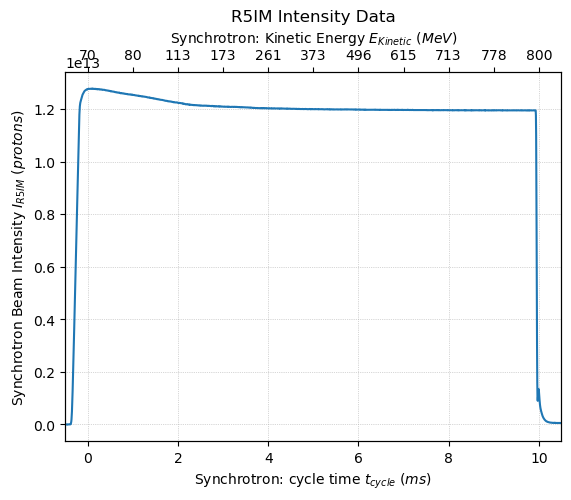

In [18]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
ax1.set_ylabel(r"Synchrotron Beam Intensity $I_{R5IM}$ $(protons)$")

ax1.plot(np.linspace(-0.5, 10.5, 2200), R5IM_data_cycle_protons)
ax1.set_xlim(-0.5, 10.5)
ax1.set_xlabel(r"Synchrotron: cycle time $t_{cycle}$ $(ms)$")
ax1.grid(which='both', ls=':', lw=0.5)

def tick_function(time):
    E = synchrotron_kinetic_energy(800., time)*1E-6
    return ["%.0f" % z for z in E]

ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(np.linspace(0., 10., 11))
ax2.set_xticklabels(tick_function(np.linspace(0., 10., 11)))
ax2.set_xlabel(r"Synchrotron: Kinetic Energy $E_{Kinetic}$ $(MeV)$");
plt.title('R5IM Intensity Data');

In [19]:
print('Maximum proton count = %0.2f' % (np.max(R5IM_data_cycle_protons)/1E13), 'x 10^13')

Maximum proton count = 1.28 x 10^13


# BLM Calibration

#### BLM Calibration Data
- x data in ms (time): [0., 3., 5., 7., 9.]
- x data in kinetic energy that correspond to these time points for this experiment: [70, 172, 374, 617, 780]
- y data in mVs per proton: [2.22E-13, 2.59E-13, 4.31E-12, 1.60E-11, 3.50E-11]
- y data in Vs per proton: [2.22E-16, 2.59E-16, 4.31E-15, 1.60E-14, 3.50E-14]

Define a numpy array to hold our x data: synchrotron cycle time in milliseconds

In [20]:
BLM_Cal_x_time = np.array([0., 3., 5., 7., 9.])

Use the `synchrotron_kinetic_energy` function to calculate the x data in synchrotron energy, in units of electron volts $eV$

In [21]:
BLM_Cal_x_energy_ev = synchrotron_kinetic_energy(800., BLM_Cal_x_time)

Convert units to give x data in Mega Electron Volts $MeV$

In [22]:
BLM_Cal_x_energy_MeV = BLM_Cal_x_energy_ev/1E6

In [23]:
BLM_Cal_x_energy_MeV

array([ 70.        , 172.56519176, 373.14021589, 614.93604999,
       777.52045636])

Make a numpy array to hold the calibration data

In [24]:
BLM_Cal_y = np.array([2.22E-16, 2.59E-16, 4.31E-15, 1.60E-14, 3.50E-14])

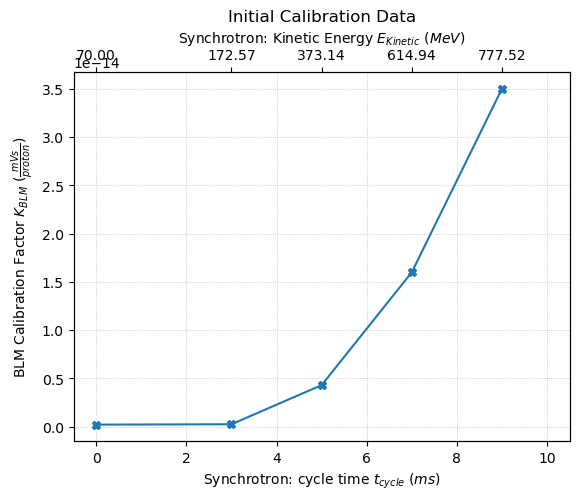

In [25]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
ax1.set_ylabel(r"BLM Calibration Factor $K_{BLM}$ $(\frac{mVs}{proton})$")

ax1.plot(BLM_Cal_x_time,BLM_Cal_y, marker='X')
ax1.set_xlim(-0.5, 10.5)
ax1.set_xlabel(r"Synchrotron: cycle time $t_{cycle}$ $(ms)$")
ax1.grid(which='both', ls=':', lw=0.5)

def tick_function(time):
    E = synchrotron_kinetic_energy(800., time)*1E-6
    return ["%.2f" % z for z in E]

ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(BLM_Cal_x_time)
ax2.set_xticklabels(tick_function(BLM_Cal_x_time))
ax2.set_xlabel(r"Synchrotron: Kinetic Energy $E_{Kinetic}$ $(MeV)$");
plt.title('Initial Calibration Data');

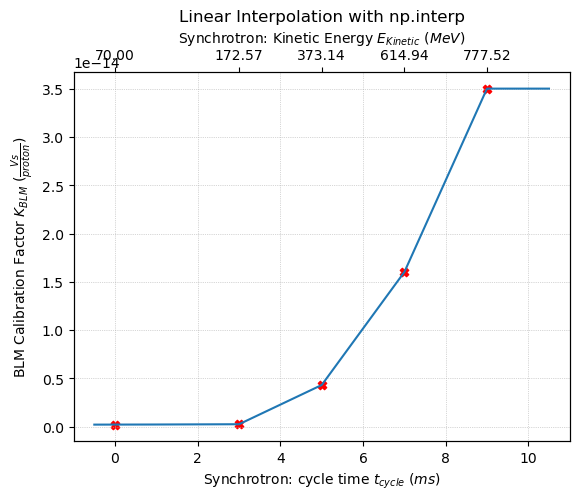

In [26]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
ax1.set_ylabel(r"BLM Calibration Factor $K_{BLM}$ $(\frac{Vs}{proton})$")

ax1.scatter(BLM_Cal_x_time,BLM_Cal_y, marker='X', c='r', label='Data')
ax1.plot(np.linspace(-0.5, 10.5, 2200), np.interp(np.linspace(-0.5, 10.5, 2200), BLM_Cal_x_time, BLM_Cal_y))

ax1.set_xlim(-1, 11)
ax1.set_xlabel(r"Synchrotron: cycle time $t_{cycle}$ $(ms)$")
ax1.grid(which='both', ls=':', lw=0.5)

def tick_function(time):
    E = synchrotron_kinetic_energy(800., time)*1E-6
    return ["%.2f" % z for z in E]

ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(BLM_Cal_x_time)
ax2.set_xticklabels(tick_function(BLM_Cal_x_time))
ax2.set_xlabel(r"Synchrotron: Kinetic Energy $E_{Kinetic}$ $(MeV)$");
plt.title('Linear Interpolation with np.interp');

## Modified method from 1F
- not tested, maybe only works for default values

In [88]:
 def divided_diff(x, y):
    '''
    function to calculate the divided
    differences table
    '''
    n = len(y)
    coef = np.zeros([n, n])
    # the first column is y
    coef[:,0] = y
    
    for j in range(1,n):
        for i in range(n-j):
            coef[i][j] = \
           (coef[i+1][j-1] - coef[i][j-1]) / (x[i+j]-x[i])
            
    return coef

def newton_poly(coef, x_data, x):
    '''
    evaluate the newton polynomial 
    at x
    '''
    n = len(x_data) - 1 
    p = coef[n]
    for k in range(1,n+1):
        p = coef[n-k] + (x -x_data[n-k])*p
    return p

 
    

def calibration_curve_beta(t_min=-0.5, t_max=10.5, data_points=2200, max_E=800):
    
    BLM_Cal_x_time = np.array([0., 3., 5., 7., 9.])
    # mVs/proton
    # BLM_Cal_y = np.array([2.22E-16, 2.59E-16, 4.31E-15, 1.60E-14, 3.50E-14])
    # vS/proton
    BLM_Cal_y = np.array([2.22E-16, 2.59E-16, 4.31E-15, 1.60E-14, 3.50E-14])  
    
    time_array = np.linspace(t_min, t_max, data_points)
    
    # Default if in storage ring mode (fixed 70 MeV)
    if max_E == 70: return get_calibration_curve(data_points, max_E)
    
    # calculate data points to pass to calibration curve (only returns between 0 - 10 ms)
    t_range = t_max - t_min
    # t_excess = t_range - 10.
    t_scale = data_points / t_range # points per millisecond
    #print(t_scale)
    cal_data_points = int(t_scale * 10)    
    pre_data_points = int(t_scale * -t_min)
    post_data_points = int(t_scale * (t_max-10))
    
    if (max_E < 800) and (cal_data_points < data_points):
        cal_data_points = (data_points - (pre_data_points+post_data_points))
    
    #assert( (cal_data_points + pre_data_points + post_data_points) == data_points), 'Sorry this function isn\'t perfect'
    
    calibration_curve = get_calibration_curve(cal_data_points, max_E)
        
    # Conditional: if time before first calibration data point, fix value
    if np.any(time_array < BLM_Cal_x_time[0]): 
        #calibration_curve[np.where(time_array < 0)] = BLM_Cal_y[0]
        calibration_curve = np.concatenate([np.ones(pre_data_points)*BLM_Cal_y[0], calibration_curve])
    
    # Find Maximum - dependent on energy
    cal_max = calibration_curve[-1]# default to interpolated 800 MeV value

    # Conditional: if time before first calibration data point, fix value
    if np.any(time_array > 10.): 
        #calibration_curve[np.where(time_array < 0)] = BLM_Cal_y[0]
        calibration_curve = np.concatenate([calibration_curve, np.ones(post_data_points)*cal_max ])
    
    # Conditional: between first two points use linear interpolation
    
    #calibration_curve[np.where(time_array < 0)] = BLM_Cal_y[0]
        
    # Original 1F method
   #return get_calibration_curve(cal_data_points, max_E) # newton_poly(a_s, BLM_Cal_x_time, time_array)
          
    return calibration_curve

In [95]:
def get_calibration_curve(data_points, max_E = 800):    
    
    BLM_Cal_x_time = np.array([0., 3., 5., 7., 9.])
    # mVs/proton
    # BLM_Cal_y = np.array([2.22E-16, 2.59E-16, 4.31E-15, 1.60E-14, 3.50E-14])
    # vS/proton
    BLM_Cal_y = np.array([2.22E-16, 2.59E-16, 4.31E-15, 1.60E-14, 3.50E-14]) 
    
    if max_E == 70: return np.ones(data_points)*BLM_Cal_y[0]    
    
    # Convert time to energy for experimental data
    E_time_array = np.linspace(0., 10., 10000)
    E_function = synchrotron_kinetic_energy(800, E_time_array)*1E-6
    
    # Get initial calibration curve for full 800 MeV ramp
    a_s = divided_diff(BLM_Cal_x_time, BLM_Cal_y)[0, :]
    
    time_array = np.linspace(0., 10., data_points)
    if max_E != 800: calibration_800_MeV = newton_poly(a_s, BLM_Cal_x_time, E_time_array)
        
    # Find correspondence between requested energy, and time in (experimental data) cycle
    for el in E_function:
        if el > max_E:
            time_index = np.where(E_function == el)[0]
            break
    
    # Get ratio of time before/after requested energy
    E_time_array_ratio = (E_time_array[-1] / E_time_array[time_index])[0]
    #print(E_time_array_ratio)
    
    # Make a new calibration curve with extra data points
    stretched_time_points = int(data_points*E_time_array_ratio)
    time_array_new = np.linspace(0., 10., stretched_time_points)
    calibration_new = newton_poly(a_s, BLM_Cal_x_time, time_array_new)
    
    # Energy curve with number of data points equal to that in calibration_new    
    E_time_array_2 = np.linspace(0., 10., len(calibration_new))
    E_function_2 = synchrotron_kinetic_energy(800, E_time_array_2)*1E-6 # energy in MeV
    
    # Get indices of first two data points (0 and 3 millliseconds) in calibration_new
    first_linear_index = 0
    second_linear_index = int(((stretched_time_points)/10)*3)
    
    # Interpolate linearly between first two points
    linear_interpolation_x = np.linspace(0, 3, second_linear_index)
    linear_interpolation = np.interp(linear_interpolation_x, BLM_Cal_x_time[0:1], BLM_Cal_y[0:1])
    
    # Replace calibration_new data between indices with linear interpolation  
    calibration_new.flat[first_linear_index:second_linear_index] = linear_interpolation
    
    # Cut out the extra data points
    return calibration_new[:data_points]

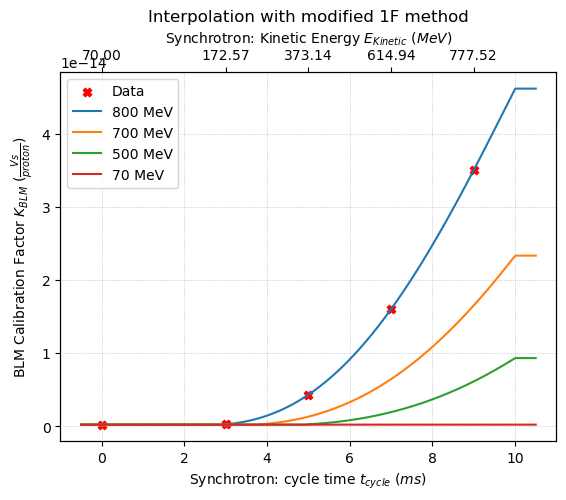

In [96]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
ax1.set_ylabel(r"BLM Calibration Factor $K_{BLM}$ $(\frac{Vs}{proton})$")

data_points = 2200
x_data = np.linspace(-0.5, 10.5, data_points)

ax1.scatter(BLM_Cal_x_time,BLM_Cal_y, marker='X', c='r', label='Data')
#ax1.plot(np.linspace(-0.5, 10.5, 2200), np.interp(np.linspace(-0.5, 10.5, 2200), BLM_Cal_x_time, BLM_Cal_y))
ax1.plot(x_data, calibration_curve_beta(), label='800 MeV')
ax1.plot(x_data, calibration_curve_beta(t_min=-0.5, t_max=10.5, data_points=2200, max_E=700), label='700 MeV')
ax1.plot(x_data, calibration_curve_beta(t_min=-0.5, t_max=10.5, data_points=2200, max_E=500), label='500 MeV')
ax1.plot(x_data, calibration_curve_beta(t_min=-0.5, t_max=10.5, data_points=2200, max_E=70), label='70 MeV')

ax1.set_xlim(-1, 11)
ax1.set_xlabel(r"Synchrotron: cycle time $t_{cycle}$ $(ms)$")
ax1.grid(which='both', ls=':', lw=0.5)
ax1.legend()

def tick_function(time):
    E = synchrotron_kinetic_energy(800., time)*1E-6
    return ["%.2f" % z for z in E]

ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(BLM_Cal_x_time)
ax2.set_xticklabels(tick_function(BLM_Cal_x_time))
ax2.set_xlabel(r"Synchrotron: Kinetic Energy $E_{Kinetic}$ $(MeV)$");
plt.title('Interpolation with modified 1F method');

#### Choose BLM data

In [30]:
BLM_data = input_data_cycle[6]

In [31]:
blm_sum_list = []
n_min = 0
n_max = 38
for i in np.linspace(n_min, n_max, int(n_max - n_min), dtype=int):
    blm_sum_list.append(input_data_cycle[i])

In [32]:
BLM_sum = np.sum(blm_sum_list, axis=0) 

#### Plot BLM Sum data

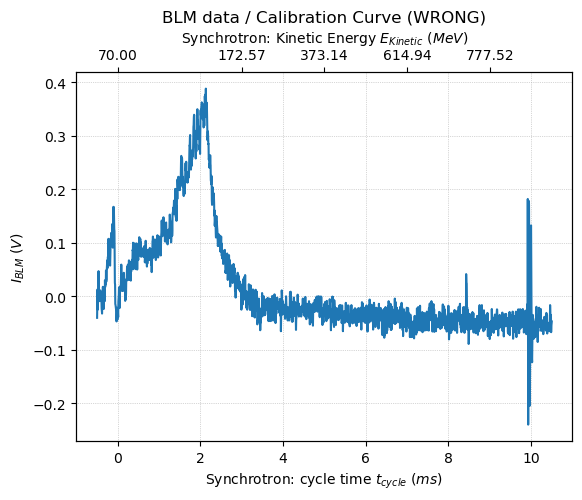

In [33]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
ax1.set_ylabel(r"$I_{BLM}~(V)$")

data_points = 2200
x_data = np.linspace(-0.5, 10.5, data_points)

ax1.plot(x_data, BLM_sum)

ax1.set_xlim(-1, 11)
ax1.set_xlabel(r"Synchrotron: cycle time $t_{cycle}$ $(ms)$")
ax1.grid(which='both', ls=':', lw=0.5)

def tick_function(time):
    E = synchrotron_kinetic_energy(800., time)*1E-6
    return ["%.2f" % z for z in E]

ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(BLM_Cal_x_time)
ax2.set_xticklabels(tick_function(BLM_Cal_x_time))
ax2.set_xlabel(r"Synchrotron: Kinetic Energy $E_{Kinetic}$ $(MeV)$");
plt.title('BLM data / Calibration Curve (WRONG)');

## Plot BLM Sum / Calibration Curve
- **INCORRECT**
- For illustration only
- Units are Protons per second (invalid)

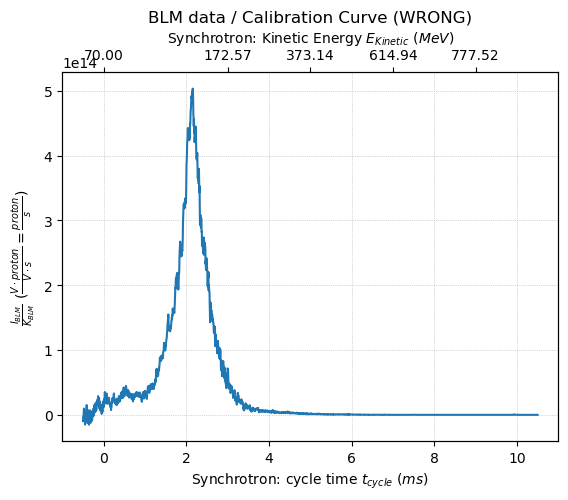

In [34]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
ax1.set_ylabel(r"$\frac{I_{BLM}}{K_{BLM}}$ $(\frac{V \cdot proton}{V \cdot s} = \frac{proton}{s})$")

data_points = 2200
x_data = np.linspace(-0.5, 10.5, data_points)

ax1.plot(x_data, BLM_data/calibration_curve_beta())

ax1.set_xlim(-1, 11)
ax1.set_xlabel(r"Synchrotron: cycle time $t_{cycle}$ $(ms)$")
ax1.grid(which='both', ls=':', lw=0.5)

def tick_function(time):
    E = synchrotron_kinetic_energy(800., time)*1E-6
    return ["%.2f" % z for z in E]

ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(BLM_Cal_x_time)
ax2.set_xticklabels(tick_function(BLM_Cal_x_time))
ax2.set_xlabel(r"Synchrotron: Kinetic Energy $E_{Kinetic}$ $(MeV)$");
plt.title('BLM data / Calibration Curve (WRONG)');

#### Need to integrate the BLM signal to get the correct units (protons) instead of the above: protons per second (invalid)

### Code from 1G

In [35]:
def find_diff_between_adj(array):
    diff_integral = np.diff(array)
    diff_integral = np.insert(diff_integral,0,array[0])
    
    return diff_integral

def get_integral_updated(x, array):
    in_array = get_integral(x, array)
    
    out_array = []
    for i in range(1, len(in_array)):
        out_array.append((in_array[i]-in_array[i-1]))
    
    return np.insert(out_array,0,in_array[0])
    #out_array = np.insert(out_array,0,in_array[0])
    #return out_array

def get_integral(x, value):
    integral = scipy.integrate.cumulative_trapezoid(value, x=x)
    
    return integral

In [36]:
integrated_BLM_data = (get_integral(np.linspace(-0.5, 10.5, 2200), BLM_sum))

In [37]:
len(integrated_BLM_data)

2199

In [38]:
integrated_BLM_data = find_diff_between_adj(get_integral(np.linspace(-0.5, 10.5, 2200), BLM_sum))

In [39]:
len(integrated_BLM_data)

2199

In [40]:
Eshers_integrated_BLM_data = get_integral_updated(np.linspace(-0.5, 10.5, 2200), BLM_sum)

In [41]:
len(get_integral_updated(np.linspace(-0.5, 10.5, 2200),BLM_data))

2199

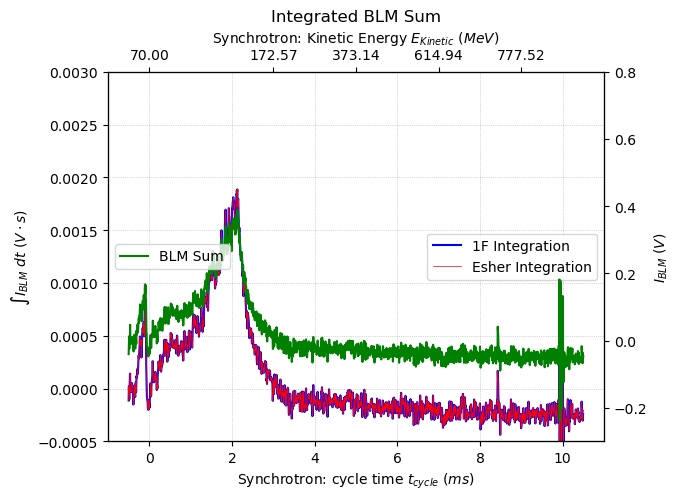

In [42]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
ax3 = ax1.twinx()
ax1.set_ylabel(r"$\int I_{BLM}~dt~(V \cdot s)$")
ax3.set_ylabel(r"$I_{BLM}~(V)$")

data_points = 2200
x_data = np.linspace(-0.5, 10.5, data_points)

ax1.plot(x_data[:-1], integrated_BLM_data, c='b', label='1F Integration')
ax1.plot(x_data[:-1], Eshers_integrated_BLM_data, c='r', lw=0.5, label='Esher Integration')
ax1.set_ylim(-0.0005, 0.003)
ax3.plot(np.linspace(-0.5, 10.5, 2200),BLM_sum, c='g', label='BLM Sum')
ax3.set_ylim(-0.3, 0.8)
ax1.legend(loc=5)
ax3.legend(loc=6)


ax1.set_xlim(-1, 11)
ax1.set_xlabel(r"Synchrotron: cycle time $t_{cycle}$ $(ms)$")
ax1.grid(which='both', ls=':', lw=0.5)

def tick_function(time):
    E = synchrotron_kinetic_energy(800., time)*1E-6
    return ["%.2f" % z for z in E]

ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(BLM_Cal_x_time)
ax2.set_xticklabels(tick_function(BLM_Cal_x_time))
ax2.set_xlabel(r"Synchrotron: Kinetic Energy $E_{Kinetic}$ $(MeV)$");
plt.title('Integrated BLM Sum');

#### Group 1G and Eshers integration methods are shown to be equivalent

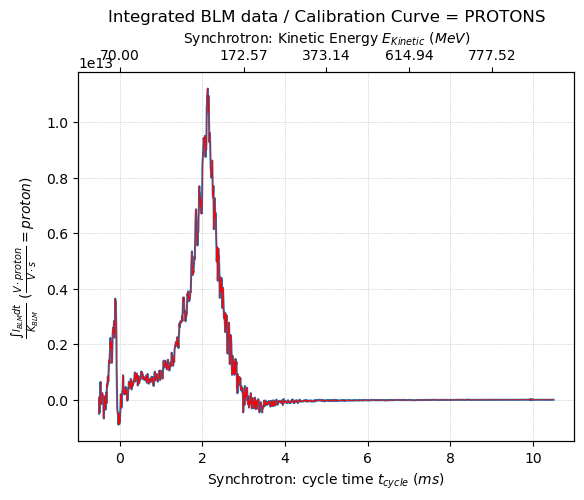

In [43]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
#ax3 = ax1.twinx()
ax1.set_ylabel(r"$\frac{\int I_{BLM} dt}{K_{BLM}}$ $(\frac{V \cdot proton}{V \cdot s} = proton)$")

data_points = 2200
x_data = np.linspace(-0.5, 10.5, data_points)
x_data2 = np.linspace(-0.5, 10.5, data_points-1)

ax1.plot(x_data[:-1], integrated_BLM_data/(calibration_curve_beta(t_min=-0.5, t_max=10.5, data_points=2200)[:-1]))
ax1.plot(x_data[:-1], Eshers_integrated_BLM_data/(calibration_curve_beta(t_min=-0.5, t_max=10.5, data_points=2200)[:-1]), c='r', lw=0.5)
#ax1.plot(x_data[:-1], get_integral_updated(x_data,BLM_data)/calibration_curve_beta(2200))

ax1.set_xlim(-1, 11)
ax1.set_xlabel(r"Synchrotron: cycle time $t_{cycle}$ $(ms)$")
ax1.grid(which='both', ls=':', lw=0.5)

def tick_function(time):
    E = synchrotron_kinetic_energy(800., time)*1E-6
    return ["%.2f" % z for z in E]

ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(BLM_Cal_x_time)
ax2.set_xticklabels(tick_function(BLM_Cal_x_time))
ax2.set_xlabel(r"Synchrotron: Kinetic Energy $E_{Kinetic}$ $(MeV)$");
plt.title('Integrated BLM data / Calibration Curve = PROTONS');

#### In the above plot we have a peak at ~ 1E13 protons - this is impossible - let's check the R5IM

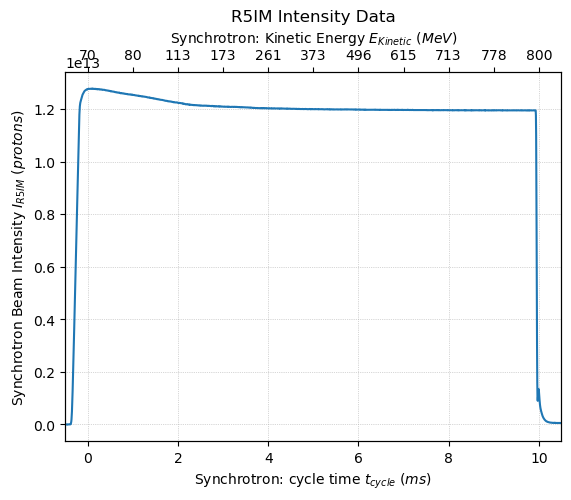

In [44]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
ax1.set_ylabel(r"Synchrotron Beam Intensity $I_{R5IM}$ $(protons)$")

ax1.plot(np.linspace(-0.5, 10.5, 2200), R5IM_data_cycle_protons)
ax1.set_xlim(-0.5, 10.5)
ax1.set_xlabel(r"Synchrotron: cycle time $t_{cycle}$ $(ms)$")
ax1.grid(which='both', ls=':', lw=0.5)

def tick_function(time):
    E = synchrotron_kinetic_energy(800., time)*1E-6
    return ["%.0f" % z for z in E]

ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(np.linspace(0., 10., 11))
ax2.set_xticklabels(tick_function(np.linspace(0., 10., 11)))
ax2.set_xlabel(r"Synchrotron: Kinetic Energy $E_{Kinetic}$ $(MeV)$");
plt.title('R5IM Intensity Data');

#### If Max(R5IM) = 1.3E13, and 1.2E13 protons survive until extraction at 10 ms, there is no way we can lose ~1E13 protons at 2 ms

We need to take into account the fact that the integration is done in milliseconds - there is a factor 1E-3 missing

In [45]:
integration_time_factor = 1E-3

In [46]:
proton_data = integrated_BLM_data/(calibration_curve_beta(t_min=-0.5, t_max=10.5, data_points=2200)[:-1])

In [47]:
Eshers_proton_data = Eshers_integrated_BLM_data/(calibration_curve_beta(t_min=-0.5, t_max=10.5, data_points=2200)[:-1])

In [48]:
proton_data_updated = proton_data * integration_time_factor

In [49]:
Eshers_proton_data_updated = Eshers_proton_data * integration_time_factor

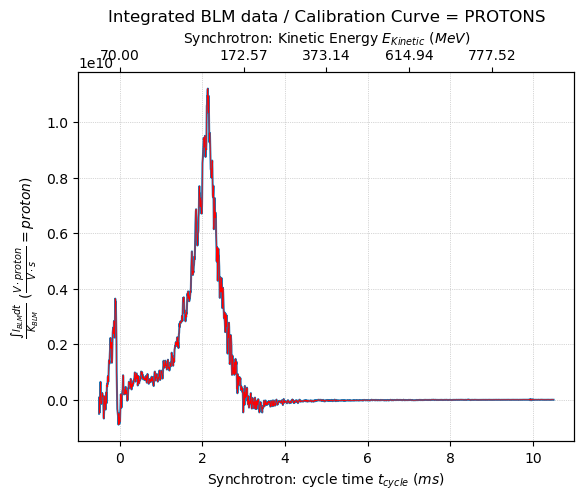

In [50]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
#ax3 = ax1.twinx()
ax1.set_ylabel(r"$\frac{\int I_{BLM} dt}{K_{BLM}}$ $(\frac{V \cdot proton}{V \cdot s} = proton)$")

data_points = 2200
x_data = np.linspace(-0.5, 10.5, data_points)
x_data2 = np.linspace(-0.5, 10.5, data_points-1)

ax1.plot(x_data[:-1], proton_data_updated)
ax1.plot(x_data[:-1], Eshers_proton_data_updated, c='r', lw=0.5)
#ax1.plot(x_data[:-1], get_integral_updated(x_data,BLM_data)/calibration_curve_beta(2200))

ax1.set_xlim(-1, 11)
ax1.set_xlabel(r"Synchrotron: cycle time $t_{cycle}$ $(ms)$")
ax1.grid(which='both', ls=':', lw=0.5)

def tick_function(time):
    E = synchrotron_kinetic_energy(800., time)*1E-6
    return ["%.2f" % z for z in E]

ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(BLM_Cal_x_time)
ax2.set_xticklabels(tick_function(BLM_Cal_x_time))
ax2.set_xlabel(r"Synchrotron: Kinetic Energy $E_{Kinetic}$ $(MeV)$");
plt.title('Integrated BLM data / Calibration Curve = PROTONS');

#### Peak loss of 1E10 protons seems sensible for a 1.3E13 proton beam

# We have protons - now convert to Joules

$$ \frac{BLM~Signal~(Volt~s)}{Calibration~Curve~\left(\frac{protons}{Volt~s}\right)} = Protons$$

$$ Protons~x~Beam~Kinetic~Energy~(electron~Volts) = Kinetic~Energy~lost~from~beam~(electron~Volts)$$

$$ Protons~x~Beam~Kinetic~Energy~(electron~Volts)~x~electron~charge~(e=1.602\cdot 10^{-19} C) = Kinetic~Energy~lost~from~beam~(Joules)$$

$$ Protons~x~Total~Beam~Energy~(electron~Volts)~x~electron~charge~(e=1.602\cdot 10^{-19}) = Kinetic~Energy~lost~from~beam~(Joules)$$

Total Beam Energy
$$E_{total} = m_0 c^2 + m c^2$$

Where:
- $m_0 c^2$ = proton rest mass = 938.27208816 MeV
- $m c^2$ = proton kinetic energy in eV

In [51]:
time_array = np.linspace(-0.5, 10.5, 2200)

In [52]:
E = synchrotron_kinetic_energy(800., time_array)

In [53]:
joules_data = proton_data_updated * (E[:-1] + 938.27208816E6) * 1.602E-19

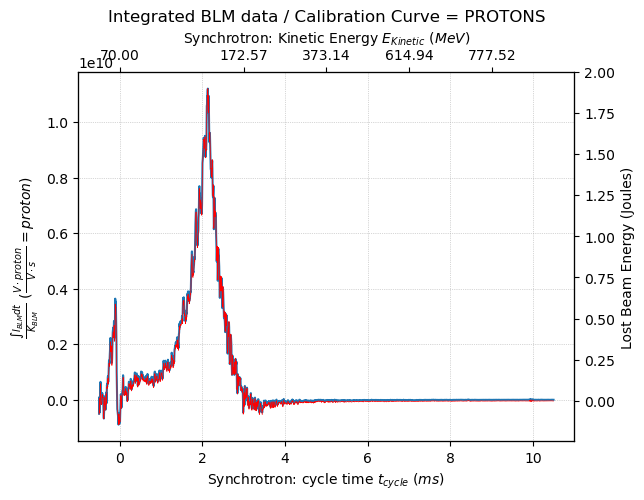

In [54]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
ax3 = ax1.twinx()
ax1.set_ylabel(r"$\frac{\int I_{BLM} dt}{K_{BLM}}$ $(\frac{V \cdot proton}{V \cdot s} = proton)$")
ax3.set_ylabel(r"Lost Beam Energy (Joules)")

data_points = 2200
x_data = np.linspace(-0.5, 10.5, data_points)
x_data2 = np.linspace(-0.5, 10.5, data_points-1)

ax1.plot(x_data[:-1], proton_data_updated)
ax3.plot(x_data[:-1], joules_data, c='r', lw=0.5)
#ax1.plot(x_data[:-1], get_integral_updated(x_data,BLM_data)/calibration_curve_beta(2200))

ax1.set_xlim(-1, 11)
ax1.set_xlabel(r"Synchrotron: cycle time $t_{cycle}$ $(ms)$")
ax1.grid(which='both', ls=':', lw=0.5)

def tick_function(time):
    E = synchrotron_kinetic_energy(800., time)*1E-6
    return ["%.2f" % z for z in E]

ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(BLM_Cal_x_time)
ax2.set_xticklabels(tick_function(BLM_Cal_x_time))
ax2.set_xlabel(r"Synchrotron: Kinetic Energy $E_{Kinetic}$ $(MeV)$");
plt.title('Integrated BLM data / Calibration Curve = PROTONS');

Integrate the area under the BLM sum (in joules)

In [55]:
integrated_BLM_test = np.abs(find_diff_between_adj(get_integral(np.linspace(-0.5, 10.5, 2200)[:-1], joules_data)))

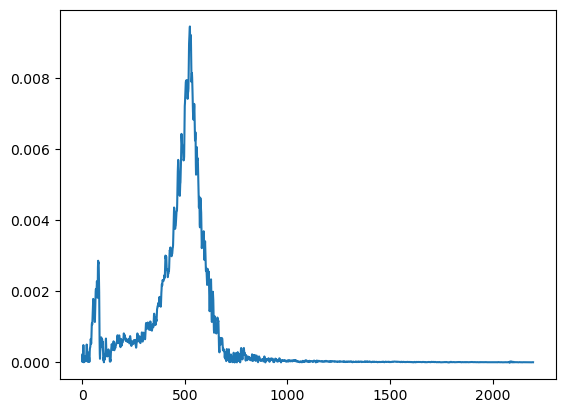

In [56]:
plt.plot(integrated_BLM_test)

In [57]:
np.sum(integrated_BLM_test)

1.5348953619349763

#### Expected Beam Power

In [58]:
((938.27208816 + 70)*1E6)*1.602E-19*1.3E13

2099.827450802016

In [59]:
((938.27208816 + 800)*1E6)*1.602E-19*1.3E13

3620.1254508020156

- Something between 2 and 4 kJ is stored in the proton beam
- 1% of the beam is thus 20 - 40 Joules
- We get 1.5 Joules - This is the correct order of magnitude as we don't expect to capture all of the 'lost' beam energy in the BLMs, they only cover a small volume of the total volume in which the proton energy is dissipated

## Test with R5IM loss data
### 70 MeV Fixed Energy (Storage Ring Mode)
- remember to use fixed calibration curve

#### Choose BLM data

In [60]:
blm_sum_list = []
n_min = 0
n_max = 38
for i in np.linspace(n_min, n_max, int(n_max - n_min), dtype=int):
    blm_sum_list.append(input_data[i])

In [61]:
BLM_sum_2 = np.sum(blm_sum_list, axis=0) 

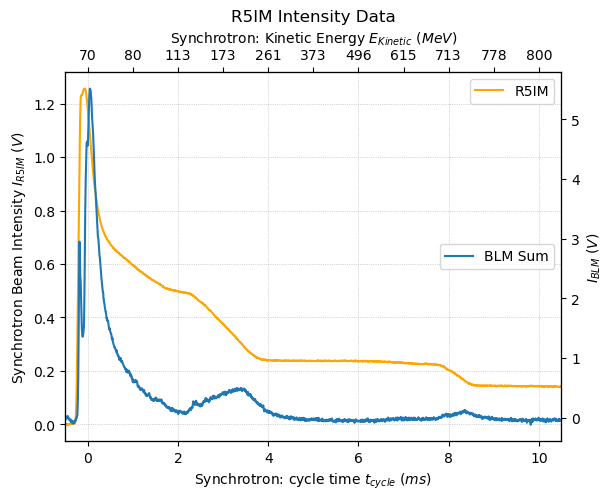

In [62]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
ax3 = ax1.twinx()
ax1.set_ylabel(r"Synchrotron Beam Intensity $I_{R5IM}$ $(V)$")
ax3.set_ylabel(r"$I_{BLM}~(V)$")

ax1.plot(np.linspace(-0.5, 10.5, 2200), R5IM_data, c='orange', label='R5IM')
ax3.plot(np.linspace(-0.5, 10.5, 2200), BLM_sum_2, label='BLM Sum')
ax1.set_xlim(-0.5, 10.5)
ax1.set_xlabel(r"Synchrotron: cycle time $t_{cycle}$ $(ms)$")
ax1.grid(which='both', ls=':', lw=0.5)
ax1.legend(loc=1)
ax3.legend(loc=5)

def tick_function(time):
    E = synchrotron_kinetic_energy(800., time)*1E-6
    return ["%.0f" % z for z in E]

ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(np.linspace(0., 10., 11))
ax2.set_xticklabels(tick_function(np.linspace(0., 10., 11)))
ax2.set_xlabel(r"Synchrotron: Kinetic Energy $E_{Kinetic}$ $(MeV)$");
plt.title('R5IM Intensity Data');

#### Integrate

In [63]:
integrated_BLM_data = (get_integral(np.linspace(-0.5, 10.5, 2200), BLM_sum_2))

#### Divide by calibration curve 

In [64]:
proton_data = integrated_BLM_data/(calibration_curve_beta(t_min=-0.5, t_max=10.5, data_points=2200, max_E=70)[:-1])

#### Multiply by time scale 

In [65]:
scaled_proton_data = proton_data * integration_time_factor

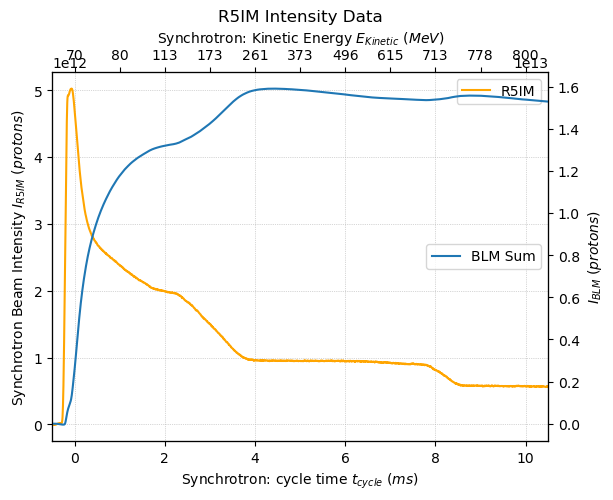

In [66]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
ax3 = ax1.twinx()
ax1.set_ylabel(r"Synchrotron Beam Intensity $I_{R5IM}$ $(protons)$")
ax3.set_ylabel(r"$I_{BLM}~(protons)$")

ax1.plot(np.linspace(-0.5, 10.5, 2200), R5IM_data_protons, c='orange', label='R5IM')
ax3.plot(np.linspace(-0.5, 10.5, 2200)[:-1], scaled_proton_data, label='BLM Sum')
ax1.set_xlim(-0.5, 10.5)
ax1.set_xlabel(r"Synchrotron: cycle time $t_{cycle}$ $(ms)$")
ax1.grid(which='both', ls=':', lw=0.5)
ax1.legend(loc=1)
ax3.legend(loc=5)


def tick_function(time):
    E = synchrotron_kinetic_energy(800., time)*1E-6
    return ["%.0f" % z for z in E]

ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(np.linspace(0., 10., 11))
ax2.set_xticklabels(tick_function(np.linspace(0., 10., 11)))
ax2.set_xlabel(r"Synchrotron: Kinetic Energy $E_{Kinetic}$ $(MeV)$");
plt.title('R5IM Intensity Data');

#### This is still incorrect - cannot lose 1.6E13 protons when $R5IM_{MAX}$ is 5E12

---
#### obsolete

In [67]:
def find_nearest(array,value):
            idx = np.searchsorted(array, value, side="left")
            if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
                return idx-1
            else:
                return idx

In [68]:
adjusted_calibration = np.interp(np.linspace(-0.5, 10.5, 2200), BLM_Cal_x_time, BLM_Cal_y)

final_calibration = (adjusted_calibration)
final_calibration[0:find_nearest(np.linspace(-0.5, 10.5, num=2200), 0)] = 0

In [69]:
len(final_calibration)

2200

/tmp/ipykernel_87121/4145049003.py:13: RuntimeWarning: divide by zero encountered in divide
  ax3.plot(x_data[:-1], (Eshers_integrated_BLM_data/final_calibration[:-1]), c='g')


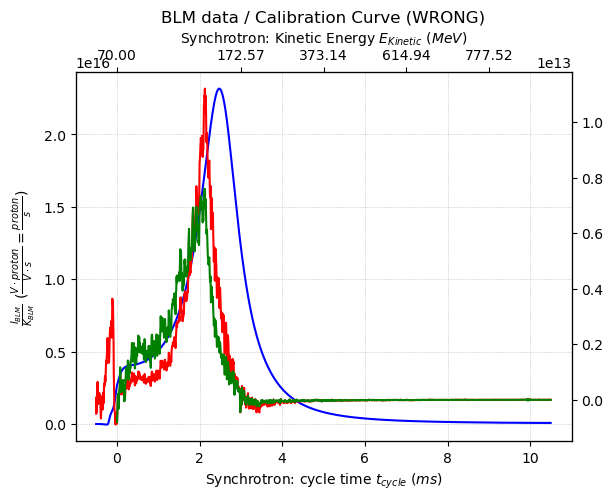

In [70]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
ax3 = ax1.twinx()
ax1.set_ylabel(r"$\frac{I_{BLM}}{K_{BLM}}$ $(\frac{V \cdot proton}{V \cdot s} = \frac{proton}{s})$")

data_points = 2200
x_data = np.linspace(-0.5, 10.5, data_points)
x_data2 = np.linspace(-0.5, 10.5, data_points-1)

ax1.plot(x_data[:-1], (integrated_BLM_data/(calibration_curve_beta(t_min=-0.5, t_max=10.5, data_points=2200)[:-1])), c='b')
ax3.plot(x_data[:-1], (Eshers_integrated_BLM_data/calibration_curve_beta(t_min=-0.5, t_max=10.5, data_points=2200)[:-1]), c='r')
ax3.plot(x_data[:-1], (Eshers_integrated_BLM_data/final_calibration[:-1]), c='g')
#ax1.plot(x_data[:-1], get_integral_updated(x_data,BLM_data)/calibration_curve_beta(2200))

ax1.set_xlim(-1, 11)
ax1.set_xlabel(r"Synchrotron: cycle time $t_{cycle}$ $(ms)$")
ax1.grid(which='both', ls=':', lw=0.5)

def tick_function(time):
    E = synchrotron_kinetic_energy(800., time)*1E-6
    return ["%.2f" % z for z in E]

ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(BLM_Cal_x_time)
ax2.set_xticklabels(tick_function(BLM_Cal_x_time))
ax2.set_xlabel(r"Synchrotron: Kinetic Energy $E_{Kinetic}$ $(MeV)$");
plt.title('BLM data / Calibration Curve (WRONG)');

### Eshers integration method

In [71]:
adjusted_calibration = np.interp(np.linspace(-0.5, 10.5, 2200), BLM_Cal_x_time, BLM_Cal_y)

final_calibration = 1/(adjusted_calibration)
final_calibration[0:find_nearest(np.linspace(-0.5, 10.5, num=2200), 0)] = 0
    

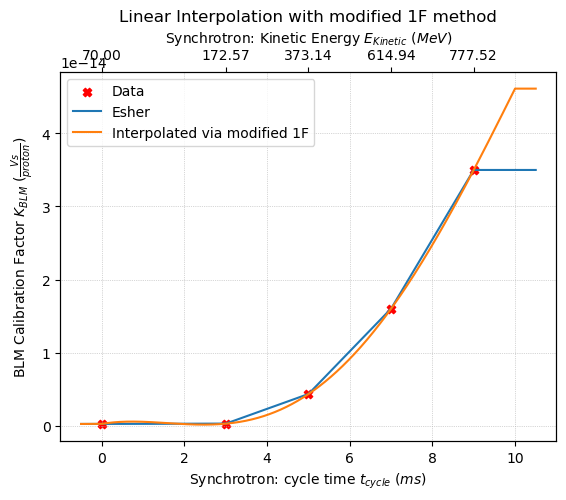

In [72]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
ax1.set_ylabel(r"BLM Calibration Factor $K_{BLM}$ $(\frac{Vs}{proton})$")

data_points = 2200
x_data = np.linspace(-0.5, 10.5, data_points)

ax1.scatter(BLM_Cal_x_time,BLM_Cal_y, marker='X', c='r', label='Data')
#ax1.plot(np.linspace(-0.5, 10.5, 2200), np.interp(np.linspace(-0.5, 10.5, 2200), BLM_Cal_x_time, BLM_Cal_y))
ax1.plot(x_data, adjusted_calibration, label='Esher')
ax1.plot(x_data, calibration_curve_beta(), label='Interpolated via modified 1F')

ax1.set_xlim(-1, 11)
ax1.set_xlabel(r"Synchrotron: cycle time $t_{cycle}$ $(ms)$")
ax1.grid(which='both', ls=':', lw=0.5)
ax1.legend()

def tick_function(time):
    E = synchrotron_kinetic_energy(800., time)*1E-6
    return ["%.2f" % z for z in E]

ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(BLM_Cal_x_time)
ax2.set_xticklabels(tick_function(BLM_Cal_x_time))
ax2.set_xlabel(r"Synchrotron: Kinetic Energy $E_{Kinetic}$ $(MeV)$");
plt.title('Linear Interpolation with modified 1F method');

#### Plot BLM Data

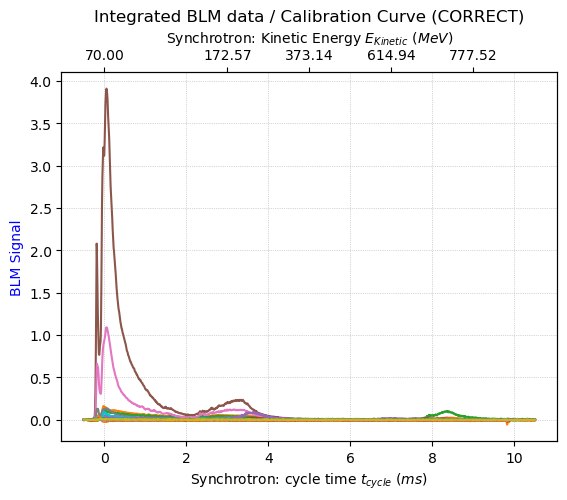

In [73]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
ax1.set_ylabel(r"BLM Signal", c='b')

data_points = 2200
x_data = np.linspace(-0.5, 10.5, data_points)

for i in (np.linspace(0,38,39, dtype=int)):
    ax1.plot(x_data, input_data[i])
#ax1.plot(x_data, BLM_sum, label='BLM Sum', c='b')
#ax1.set_ylim(-1, 10)


#ax1.set_xlim(-1, 11)
ax1.set_xlabel(r"Synchrotron: cycle time $t_{cycle}$ $(ms)$")
ax1.grid(which='both', ls=':', lw=0.5)

def tick_function(time):
    E = synchrotron_kinetic_energy(800., time)*1E-6
    return ["%.2f" % z for z in E]

ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(BLM_Cal_x_time)
ax2.set_xticklabels(tick_function(BLM_Cal_x_time))
ax2.set_xlabel(r"Synchrotron: Kinetic Energy $E_{Kinetic}$ $(MeV)$");
plt.title('Integrated BLM data / Calibration Curve (CORRECT)');

#### Find BLM Sum

In [74]:
blm_sum_list = []
n_min = 0
n_max = 39
for i in np.linspace(n_min, n_max, int(n_max - n_min), dtype=int):
    blm_sum_list.append(input_data[i])

In [75]:
BLM_sum = np.sum(blm_sum_list, axis=0) 

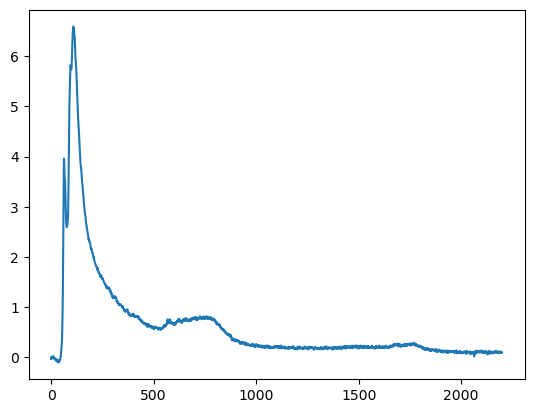

In [76]:
plt.plot(BLM_sum)

#### Integrate BLM Sum

In [77]:
cumulative_sum = integrate.cumulative_trapezoid(BLM_sum, x = np.linspace(-0.5, 10.5, 2200))

#cumulative_sum will be in V s, invert to get V s

#integrated_sum is an array of all integrated bins between start and stop
integrated_sum = [0]
integrated_sum[0] = cumulative_sum[0]
for i in range(1, len(cumulative_sum)):
    integrated_sum.append((cumulative_sum[i]-cumulative_sum[i-1]))
protons_per_bin = ((np.array(integrated_sum)) * (np.delete(final_calibration, [0])))

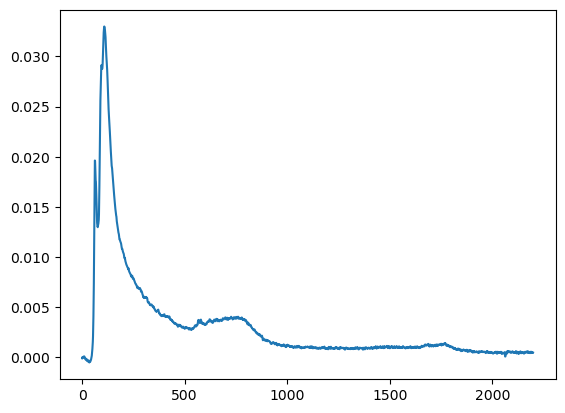

In [78]:
plt.plot(integrated_sum)

In [79]:
Eshers_integrated_BLM_data = get_integral_updated(np.linspace(-0.5, 10.5, 2200),BLM_data)

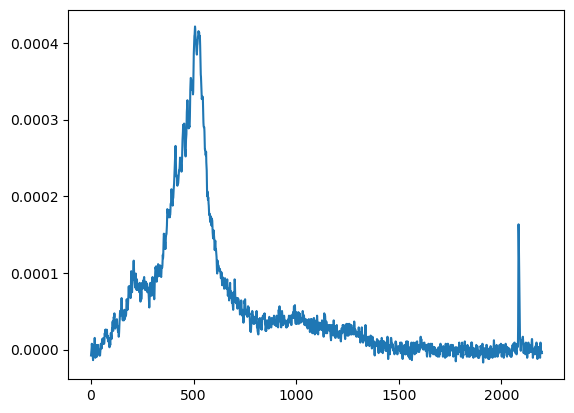

In [80]:
plt.plot(Eshers_integrated_BLM_data)

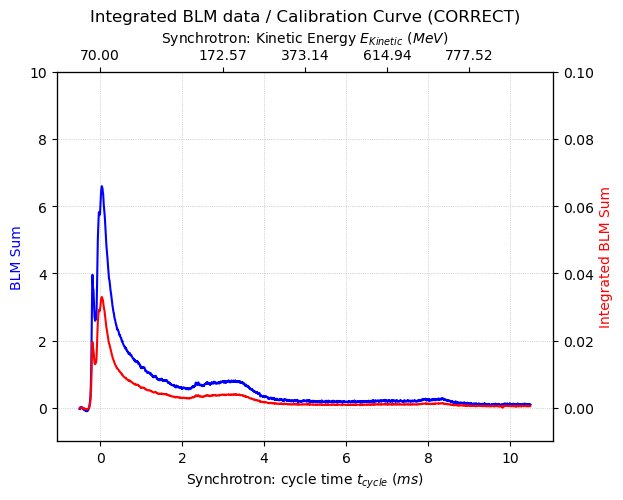

In [81]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
ax3 = ax1.twinx()
ax1.set_ylabel(r"BLM Sum", c='b')

data_points = 2200
x_data = np.linspace(-0.5, 10.5, data_points)

ax1.plot(x_data, BLM_sum, label='BLM Sum', c='b')
ax1.set_ylim(-1, 10)
ax3.plot(x_data[:-1], integrated_sum, label='Integrated Sum', c='r')
ax3.set_ylim(-0.01, 0.1)
ax3.set_ylabel(r"Integrated BLM Sum", c='r')

#ax1.set_xlim(-1, 11)
ax1.set_xlabel(r"Synchrotron: cycle time $t_{cycle}$ $(ms)$")
ax1.grid(which='both', ls=':', lw=0.5)

def tick_function(time):
    E = synchrotron_kinetic_energy(800., time)*1E-6
    return ["%.2f" % z for z in E]

ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(BLM_Cal_x_time)
ax2.set_xticklabels(tick_function(BLM_Cal_x_time))
ax2.set_xlabel(r"Synchrotron: Kinetic Energy $E_{Kinetic}$ $(MeV)$");
plt.title('Integrated BLM data / Calibration Curve (CORRECT)');

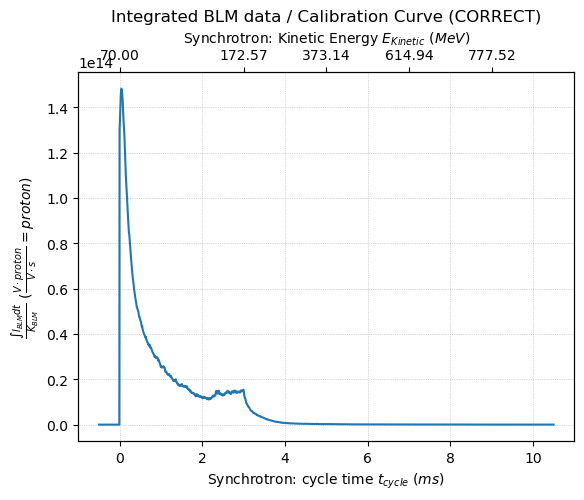

In [82]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
ax1.set_ylabel(r"$\frac{\int I_{BLM} dt}{K_{BLM}}$ $(\frac{V \cdot proton}{V \cdot s} = proton)$")

data_points = 2200
x_data = np.linspace(-0.5, 10.5, data_points)

ax1.plot(x_data[:-1], protons_per_bin)

ax1.set_xlim(-1, 11)
ax1.set_xlabel(r"Synchrotron: cycle time $t_{cycle}$ $(ms)$")
ax1.grid(which='both', ls=':', lw=0.5)

def tick_function(time):
    E = synchrotron_kinetic_energy(800., time)*1E-6
    return ["%.2f" % z for z in E]

ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(BLM_Cal_x_time)
ax2.set_xticklabels(tick_function(BLM_Cal_x_time))
ax2.set_xlabel(r"Synchrotron: Kinetic Energy $E_{Kinetic}$ $(MeV)$");
plt.title('Integrated BLM data / Calibration Curve (CORRECT)');